In [1]:
# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import string
import nltk
import os
import random

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

In [2]:
# Load data
init_df = pd.read_json('News_Category_Dataset_v3.json', lines=True)[['headline', 'category']]
init_df.head(10)

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS
5,Cleaner Was Dead In Belk Bathroom For 4 Days B...,U.S. NEWS
6,Reporter Gets Adorable Surprise From Her Boyfr...,U.S. NEWS
7,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS
8,How A New Documentary Captures The Complexity ...,CULTURE & ARTS
9,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS


In [3]:
init_df['category'].value_counts()[:15]

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
Name: category, dtype: int64

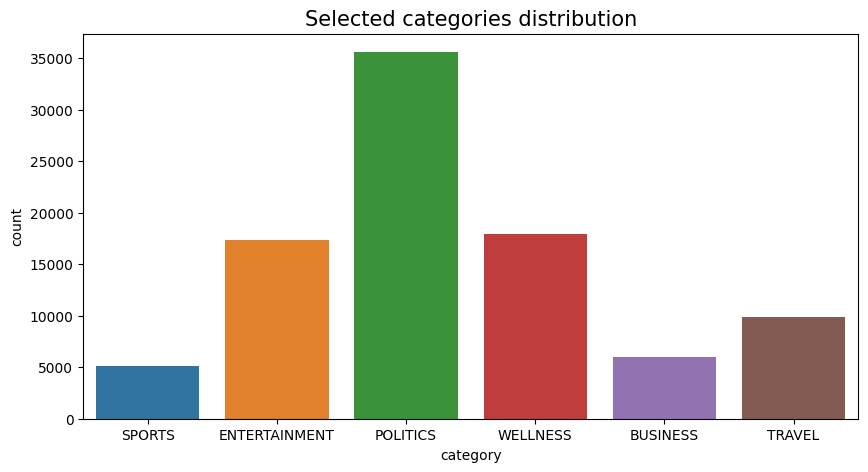

In [4]:
# Show selected categories
selected_categories = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'BUSINESS', 'SPORTS']
selected_df = init_df[init_df['category'].isin(selected_categories)]
plt.figure(figsize = [10, 5])
sns.countplot(x=selected_df["category"])
plt.title("Selected categories distribution", fontsize = 15)
plt.show()

In [30]:
selected_df['category'].value_counts()

POLITICS         35602
WELLNESS         17945
ENTERTAINMENT    17362
TRAVEL            9900
BUSINESS          5992
SPORTS            5077
Name: category, dtype: int64

In [41]:
# Downsampling the data
#selected_df['category'].value_counts().sort_values([0])
SEED = 1234
df_downsample = init_df[init_df['category'] == selected_df['category'].value_counts().sort_values().index[0]].sample(n=selected_df['category'].value_counts().sort_values()[0], random_state=SEED)
for i in range(len(selected_df['category'].unique()) - 1):
    df_downsample = pd.concat([df_downsample, init_df[init_df['category'] == selected_df['category'].value_counts().sort_values().index[i + 1]].sample(n=selected_df['category'].value_counts().sort_values()[0], random_state=SEED)])

In [42]:
df_downsample

,headline,category
126151,The World Cup Winners Selfie Is The Best Ever,SPORTS
79277,"Clemson Beats Oklahoma, Advancing To National ...",SPORTS
126270,"With The World Watching, Titans Take To The Pitch",SPORTS
133313,GIFs: The Memphis Grizzlies Weathered This Epi...,SPORTS
118554,Inside The NFL's Megadeals,SPORTS
...,...,...
1960,Legal Experts Spot The Fatal Flaws With Donald...,POLITICS
1069,Utah Gov. Spencer Cox Says He Plans To Veto Tr...,POLITICS
42602,"News Roundup for February 20, 2017",POLITICS
39830,Tillerson Orders U.S. Embassies To Identify Po...,POLITICS


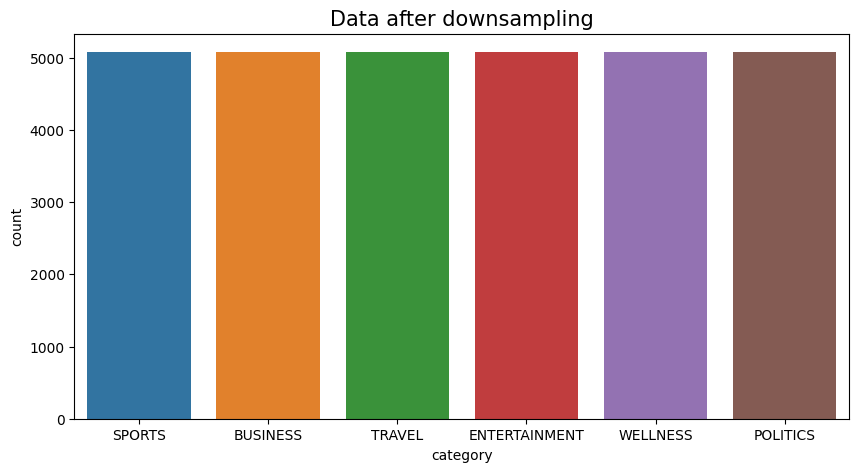

In [262]:
# Show data distribution after upsampling
plt.figure(figsize = [10, 5])
sns.countplot(x=df_downsample["category"])
plt.title("Data after downsampling", fontsize = 15)
plt.show()

In [46]:
# NLP preprocess stuff
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

In [47]:
# Text cleaning
df_downsample["text"] = df_downsample["headline"]
df_downsample['text'] = df_downsample['text'].map(lambda x: clean_text(x))
X, y = df_downsample['text'], df_downsample["category"]

In [48]:
X.iloc[:10]

126151                    world cup winner selfie best ever
79277     clemson beat oklahoma advancing national champ...
126270                      world watching titan take pitch
133313    gifs memphis grizzly weathered epic oklahoma c...
118554                                inside nfls megadeals
49550     warrior coach steve kerr say used marijuana ba...
53636           everyone went nut goldberg returned wwe raw
71030      keith olbermann reveals forced leave trump tower
63198     former international phenomenon linsanity retu...
187404                        31 new tommy john surgery mlb
Name: text, dtype: object

In [50]:
# Train test split on the upsampled data
X_train, X_test, y_train, y_test = train_test_split(df_downsample['text'], df_downsample['category'], test_size=0.2, stratify=df_downsample['category'])

# Encoding categories
le = preprocessing.LabelEncoder()
le.fit(selected_categories)
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)

# tf-idf vectorizer
tf_idf_vectorizer = TfidfVectorizer()
X_train_t = tf_idf_vectorizer.fit_transform(X_train)
X_test_t = tf_idf_vectorizer.transform(X_test)
print(X_train.shape, X_train_t.shape)

(24369,) (24369, 21548)


In [267]:
# Dummy Classifier
dc = DummyClassifier(strategy="stratified")
dc.fit(X_train_t, y_train_label)
pred_dc = dc.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_dc)))
print("Dummy Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dc), average='weighted'))
print("Dummy Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dc)))

               precision    recall  f1-score   support

     BUSINESS       0.17      0.17      0.17      1015
ENTERTAINMENT       0.16      0.17      0.17      1016
     POLITICS       0.17      0.17      0.17      1015
       SPORTS       0.16      0.16      0.16      1016
       TRAVEL       0.18      0.18      0.18      1016
     WELLNESS       0.16      0.16      0.16      1015

     accuracy                           0.17      6093
    macro avg       0.17      0.17      0.17      6093
 weighted avg       0.17      0.17      0.17      6093

Dummy Classifier f1-Score: 0.16889946144012458
Dummy Classifier accuracy: 0.1688823239783358


In [270]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_t, y_train_label)
pred_dt = dt.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_dt)))
print("Decision Tree Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dt), average='weighted'))
print("Decision Tree Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dt)))

               precision    recall  f1-score   support

     BUSINESS       0.61      0.57      0.59      1015
ENTERTAINMENT       0.67      0.62      0.64      1016
     POLITICS       0.69      0.69      0.69      1015
       SPORTS       0.74      0.67      0.70      1016
       TRAVEL       0.70      0.69      0.70      1016
     WELLNESS       0.56      0.71      0.62      1015

     accuracy                           0.66      6093
    macro avg       0.66      0.66      0.66      6093
 weighted avg       0.66      0.66      0.66      6093

Decision Tree Classifier f1-Score: 0.6578703383359373
Decision Tree Classifier accuracy: 0.6571475463646808


In [271]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train_t, y_train_label)
pred_rf = rf.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_rf)))
print("Random Forest Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_rf), average='weighted'))
print("Random Forest Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_rf)))

               precision    recall  f1-score   support

     BUSINESS       0.74      0.62      0.68      1015
ENTERTAINMENT       0.78      0.68      0.72      1016
     POLITICS       0.77      0.77      0.77      1015
       SPORTS       0.81      0.75      0.77      1016
       TRAVEL       0.77      0.76      0.76      1016
     WELLNESS       0.58      0.80      0.67      1015

     accuracy                           0.73      6093
    macro avg       0.74      0.73      0.73      6093
 weighted avg       0.74      0.73      0.73      6093

Random Forest Classifier f1-Score: 0.7303798861591797
Random Forest Classifier accuracy: 0.729033316921057


In [272]:
# K-Nearest Neighbors Classifier
svd = TruncatedSVD(n_components=7, random_state=SEED, n_iter=7)
X_train_t_final = svd.fit_transform(X_train_t)
X_test_t_final = svd.transform(X_test_t)

knn = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
knn.fit(X_train_t_final, y_train_label)
pred_knn = knn.predict(X_test_t_final)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn)))
print("K-Nearest Neighbors Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn), average='weighted'))
print("K-Nearest Neighbors Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn)))

               precision    recall  f1-score   support

     BUSINESS       0.39      0.46      0.42      1015
ENTERTAINMENT       0.38      0.43      0.41      1016
     POLITICS       0.60      0.61      0.61      1015
       SPORTS       0.50      0.45      0.48      1016
       TRAVEL       0.68      0.63      0.66      1016
     WELLNESS       0.50      0.43      0.46      1015

     accuracy                           0.50      6093
    macro avg       0.51      0.50      0.50      6093
 weighted avg       0.51      0.50      0.50      6093

K-Nearest Neighbors Classifier f1-Score: 0.5038342462099954
K-Nearest Neighbors Classifier accuracy: 0.5013950434925324


In [273]:
# C-Support Vector Classifier
svc = SVC()
svc.fit(X_train_t, y_train_label)
pred_svc = svc.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_svc)))
print("C-Support Vector Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_svc), average='weighted'))
print("C-Support Vector Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_svc)))

               precision    recall  f1-score   support

     BUSINESS       0.74      0.74      0.74      1015
ENTERTAINMENT       0.80      0.82      0.81      1016
     POLITICS       0.81      0.80      0.81      1015
       SPORTS       0.87      0.82      0.85      1016
       TRAVEL       0.88      0.82      0.85      1016
     WELLNESS       0.72      0.80      0.76      1015

     accuracy                           0.80      6093
    macro avg       0.80      0.80      0.80      6093
 weighted avg       0.80      0.80      0.80      6093

C-Support Vector Classifier f1-Score: 0.8018921354280883
C-Support Vector Classifier accuracy: 0.8010832102412605


In [274]:
# Multinomial Naive Bayes Classifier
mnb = MultinomialNB(alpha=1e-4, fit_prior=False)
mnb.fit(X_train_t, y_train_label)
pred_mnb = mnb.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_mnb)))
print("Multinomial Naive Bayes Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_mnb), average='weighted'))
print("Multinomial Naive Bayes Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_mnb)))

               precision    recall  f1-score   support

     BUSINESS       0.65      0.64      0.65      1015
ENTERTAINMENT       0.71      0.76      0.74      1016
     POLITICS       0.70      0.73      0.71      1015
       SPORTS       0.77      0.79      0.78      1016
       TRAVEL       0.79      0.76      0.78      1016
     WELLNESS       0.74      0.68      0.71      1015

     accuracy                           0.73      6093
    macro avg       0.73      0.73      0.73      6093
 weighted avg       0.73      0.73      0.73      6093

Multinomial Naive Bayes Classifier f1-Score: 0.7268187203365718
Multinomial Naive Bayes Classifier accuracy: 0.7270638437551289


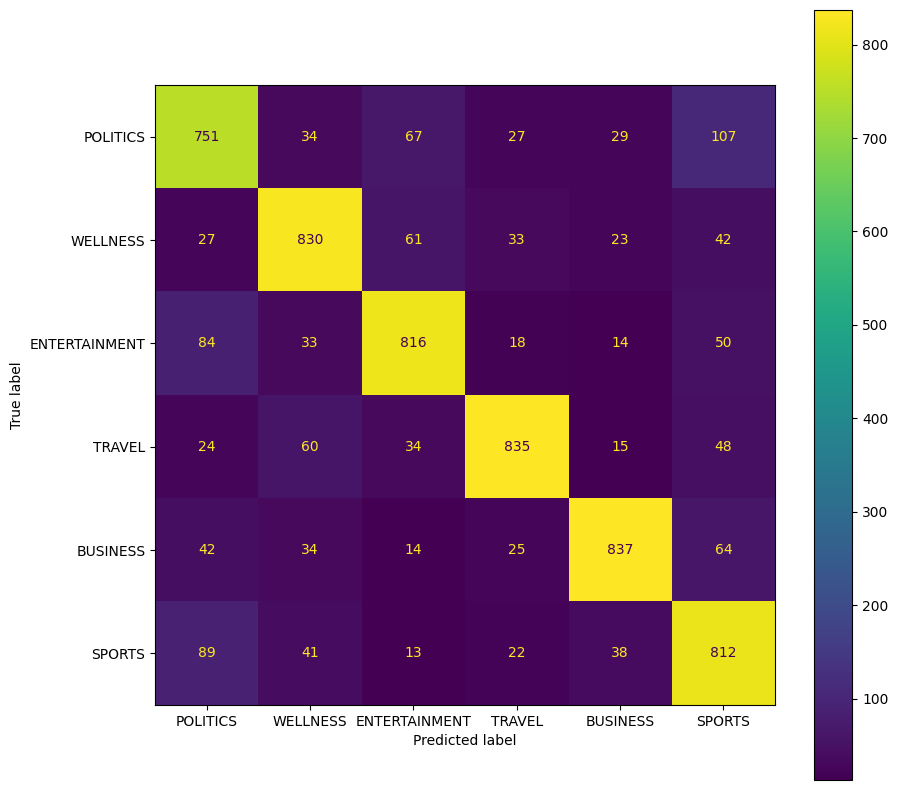

In [62]:
# Confusion Matrix for the most accurate model (C-Support Vector Classifier)
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix_svc = metrics.confusion_matrix(y_test_label.tolist(), pred_svc.tolist())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_svc, display_labels = selected_categories)
cm_display.plot(ax=ax)
plt.show()

In [69]:
# LSTM model
# Max of the length for padding
maxlen = 200

# Tokenize
oov_token = "<oov_token>"
tokenizer = Tokenizer(oov_token = oov_token)
tokenizer.fit_on_texts(df_downsample.text.to_list()) 

# The word_index dictionary assigns a unique index to each unique word
word_index = {}
word_index = tokenizer.word_index
vocabulary = len(word_index) +1
print('Vocabulary : {}'.format(vocabulary))

# Convert into padded sequences                                               
X_tokenizer = tokenizer.texts_to_sequences(df_downsample.text.to_list())
X_padded = pad_sequences(X_tokenizer, maxlen=maxlen, truncating='post',padding='pre')
print('Shape of data tensor:', X_padded.shape)

# One-hot encoding for classes
Y = pd.get_dummies(df_downsample['category'].values)
print('Shape of label tensor:', Y.shape)

# Split data
X_train_padded, X_test_padded, Y_train_dummy, Y_test_dummy = train_test_split(X_padded, Y, test_size=0.2, random_state=SEED)
print(X_train_padded.shape,Y_train_dummy.shape)
print(X_test_padded.shape,Y_test_dummy.shape)
Y.head()

Vocabulary : 24097
Shape of data tensor: (30462, 200)
Shape of label tensor: (30462, 6)
(24369, 200) (24369, 6)
(6093, 200) (6093, 6)


,BUSINESS,ENTERTAINMENT,POLITICS,SPORTS,TRAVEL,WELLNESS
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [70]:
X_tokenizer[0]

[5, 189, 452, 1133, 10, 164]

In [71]:
X_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [72]:
# Load glove
glove_dictionary = {}
with open('./glove6b/glove.6B.200d.txt',encoding="utf8") as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [73]:
# Initiating empty vectors for new words (which are missing in glove)
embedding_matrix = np.zeros((vocabulary, maxlen))

# The glove_dictionary contains words vs their respective embeddings. Create the embedding matrix using the glove_dictionary
for word, i in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [74]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [206]:
def build_model(embed_weights):
  
    embedding_output_dims = 200
    model = tf.keras.Sequential()
    
    model.add(Embedding(vocabulary, embedding_output_dims, weights=[embed_weights], input_length=maxlen))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.2))
    # Final layer : add output layer and activation 
    model.add(Dense(6, activation='sigmoid'))

    # Use a loss function, optimizer as adam to compile 
    # and evaluate model on auc,precision,recall,accuracy
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['AUC', 'Recall', 'Precision', 'accuracy'])
    
    print(model.summary)
    return model

In [207]:
epochs = 100

model = build_model(embedding_matrix)

# train and validate the model on the padded sequences of text which we have created initially       
history = model.fit(X_train_padded, 
                    Y_train_dummy, 
                    epochs=epochs, 
                    verbose=1,
                    batch_size=64,
                    validation_split=0.1,
                    validation_data=(X_test_padded, Y_test_dummy))

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002FA7B4C5120>>
Epoch 1/100
381/381 [==============================] - 13s 30ms/step - loss: 1.7869 - auc: 0.5365 - recall: 0.6840 - precision: 0.1771 - accuracy: 0.2050 - val_loss: 1.7418 - val_auc: 0.6472 - val_recall: 0.8244 - val_precision: 0.2047 - val_accuracy: 0.2828
Epoch 2/100
381/381 [==============================] - 10s 27ms/step - loss: 1.7112 - auc: 0.6568 - recall: 0.7856 - precision: 0.2114 - accuracy: 0.3044 - val_loss: 1.6560 - val_auc: 0.7658 - val_recall: 0.8853 - val_precision: 0.2390 - val_accuracy: 0.4334
Epoch 3/100
381/381 [==============================] - 10s 27ms/step - loss: 1.6210 - auc: 0.7358 - recall: 0.8444 - precision: 0.2369 - accuracy: 0.4098 - val_loss: 1.5473 - val_auc: 0.8168 - val_recall: 0.9089 - val_precision: 0.2593 - val_accuracy: 0.5418
Epoch 4/100
381/381 [==============================] - 10s 27ms/step - loss: 1.5082 - auc: 0.7845 - recall: 0.8793 - precisio

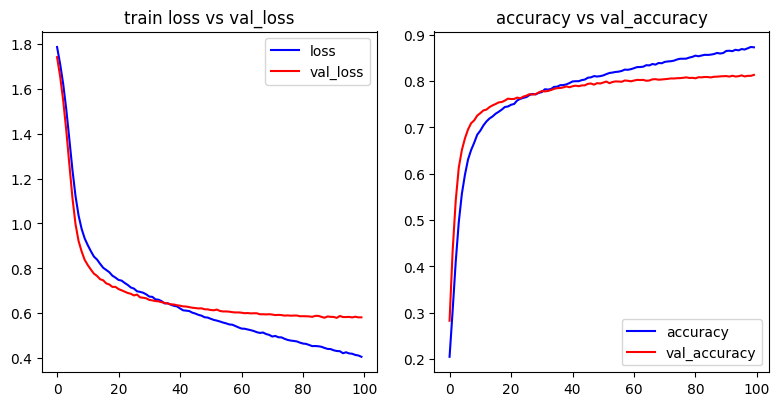

In [208]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.tight_layout()

axs[0].plot(history.history['loss'], 'b', label = 'loss')
axs[0].plot(history.history['val_loss'], 'r', label = 'val_loss')
axs[0].set_title("train loss vs val_loss")
axs[0].legend()

axs[1].plot(history.history['accuracy'], 'b', label = 'accuracy')
axs[1].plot(history.history['val_accuracy'], 'r', label = 'val_accuracy')
axs[1].set_title("accuracy vs val_accuracy")
axs[1].legend()

plt.show()

In [246]:
model.save('news_classification')

INFO:tensorflow:Assets written to: news_classification\assets


INFO:tensorflow:Assets written to: news_classification\assets


In [233]:
def predict_category(text):
    # Tokenize and pad
    tokenized_text = tokenizer.texts_to_sequences([text])
    tokenized_text_padded = pad_sequences(tokenized_text, maxlen=maxlen, truncating='post', padding='pre')

    #The higherst probability score will be saved as prediction category
    prediction = model.predict(tokenized_text_padded, verbose=0)[0].tolist()
    index = prediction.index(max(prediction))
    categories = Y.columns.to_list()
    pred_category = categories[index]
    return pred_category

In [249]:
# Test on 5 random rows
random_sample = random.sample(range(0, X.shape[0]), 5)
for i in random_sample:
    print(df_downsample['headline'].iloc[i], '\n::: TRUE - PREDICT :::', df_downsample['category'].iloc[i], '-', predict_category(X.iloc[i]), ':::\n')

Bernie Sanders Calls Out Media For Not Covering Obama's Trade Deal 
::: TRUE - PREDICT ::: POLITICS - POLITICS :::

Chrissy Teigen And John Legend's Lovey Duet Wins Valentine's Day 
::: TRUE - PREDICT ::: ENTERTAINMENT - ENTERTAINMENT :::

5 Ways Bernie Sanders May Impact The Democratic Party Platform 
::: TRUE - PREDICT ::: POLITICS - POLITICS :::

The Confessions Of Being A Freelance Writer 
::: TRUE - PREDICT ::: BUSINESS - BUSINESS :::

Theater: Cloudy Little Miss Sunshine; Digestive Proust 
::: TRUE - PREDICT ::: ENTERTAINMENT - ENTERTAINMENT :::



In [252]:
# Load our data
df_reddit = pd.read_json('data.json', lines=True)[['title']]

In [257]:
# Preprocess and predict
df_reddit['cleaned_title'] = df_reddit['title'].map(lambda x: clean_text(x))
df_reddit['pred_news_category'] = df_reddit['cleaned_title'].map(lambda x: predict_category(x))

In [258]:
df_reddit.head(10)

,title,cleaned_title,pred_news_category
0,People Are Accusing Robinhood Of Stealing From...,people accusing robinhood stealing poor give r...,BUSINESS
1,US Military Could Lose Space Force Trademark t...,u military could lose space force trademark ne...,POLITICS
2,White House threatens to fire anyone who tries...,white house threatens fire anyone try quit,POLITICS
3,Meta's threat to close down Facebook and Insta...,metas threat close facebook instagram europe b...,POLITICS
4,Don't eat or inject yourself with disinfectant...,dont eat inject disinfectant warns fda commiss...,WELLNESS
5,Hiker lost on mountain for 24 hours ignored ca...,hiker lost mountain 24 hour ignored call rescu...,TRAVEL
6,Coronavirus homeschooling: 77 percent of paren...,coronavirus homeschooling 77 percent parent ag...,WELLNESS
7,Louisiana eye doctor offers free eye exams for...,louisiana eye doctor offer free eye exam nfl r...,SPORTS
8,United States Risks Sanctions From Zimbabwe If...,united state risk sanction zimbabwe election f...,POLITICS
9,DoorDash Spent $5.5 Million To Advertise Their...,doordash spent 55 million advertise 1 million ...,POLITICS


In [260]:
df_reddit.pred_news_category.value_counts()

POLITICS         4798
BUSINESS         1643
ENTERTAINMENT    1052
SPORTS            992
TRAVEL            763
WELLNESS          654
Name: pred_news_category, dtype: int64

In [269]:
df_reddit[['title', 'pred_news_category']].to_csv('pred_news_titles.csv', index=False)